In [1]:
import jax
import jaxlib
import jax.numpy as np
import numpy as onp
import cantera as ct
import scipy
import os
from scipy.integrate import solve_ivp
from functools import partial
from jax.config import config
config.update("jax_enable_x64", True)
print(f"Using jax: {jax.__version__}")
print(f"Using jaxlib: {jaxlib.__version__}")
print(f"Using cantera: {ct.__version__}")

Using jax: 0.1.66
Using jaxlib: 0.1.47
Using cantera: 2.5.0a3


In [2]:
#jax reactor
from jax_reactor import kinetics, thermo, solution, dataclass

# Use Cantera to set up simulation

In [3]:
gas = ct.Solution('gri30.yaml')

In [4]:
#Global parameters 
T = 1001.
P = ct.one_atm
R = ct.gas_constant
X = 'H2:2,O2:1,N2:4'

In [5]:
gas.TPX = T, P, X

# Get  initial mole fractions (Y) and gas_info as namedtuple

In [6]:
Y, gas_info = solution.get_initial_mole_fractions_and_state('gri30.yaml',T, P, X)

# Get NASA polynomials, kinetics parameters from YAML 

In [7]:
yaml_file = os.path.expanduser('~/Code/cantera/data/gri30.yaml')
mechanism_dict = dataclass.load_yaml(yaml_file)
nasa_poly = dataclass.get_nasa_polynomials_from_yaml(mechanism_dict)
kinetics_coeffs, kinetics_data =  dataclass.get_kinetic_parameters_from_yaml(mechanism_dict, gas)

# Get dYdt 

In [8]:
#use partial to hoist all parameters so we get a function of type f(t,y) for solve_ivp
get_dYdt_with_options=partial(solution.get_dYdt, P, R, gas_info, nasa_poly, kinetics_coeffs, kinetics_data)

In [9]:
#JIT the function
jitted_get_dYdt_with_options = jax.jit(get_dYdt_with_options)

# Get Jacobian using forward mode automatic differentiation

In [10]:
jac_fwd = jax.jacfwd(get_dYdt_with_options,(1,)) # fwd mode jacobian w.r.t to 2nd arguement(state_vec)
jit_jac_fwd = jax.jit(jac_fwd)

In [11]:
def get_jac(t, state_vec):
    jac = jit_jac_fwd(t,state_vec)
    return jac[0]

# Initial Conditions

In [12]:
Y0 = np.hstack((T, Y))

# Use JAX based BDF solver to integrate and save results 

In [13]:
from jax_reactor.solver.bdf import bdf_solve

In [14]:
def lax_scan_to_end_time(ode_fn, jacobian_fn, initial_state, ts, dt):
    
    def scan_fun(carry, target_t):
    
        def cond_fn(_state):
            i, _, current_time, success = _state
            return (current_time<target_t) & success

        def step(_state):
            i, current_state, current_time, _ = _state
            results = bdf_solve(ode_fn,
                            current_time,
                            current_state,
                            np.array([current_time, current_time+dt]),
                            jacobian_fn)
            next_state = results.states[-1]
            next_time = results.times[-1]
            success = np.equal(results.diagnostics.status,0)
            return [i+1, next_state, next_time, success]
    
        _,*carry = jax.lax.while_loop(cond_fn, step, [0]+carry) 
        y_target, _, _ = carry
        return carry, y_target
    
    
    init_carry = [initial_state, 0.0, True]
    
    _, ys = jax.lax.scan(scan_fun, init_carry, ts[1:])
    
    return np.concatenate((initial_state[None],ys))
        

In [15]:
jitted_scan_to_end_time = jax.jit(lax_scan_to_end_time, static_argnums=(0,1))

# Integrate to end_time using JAX control flow

In [16]:
ts = np.arange(0.0, 1e-3,1e-5)
ys = lax_scan_to_end_time(jitted_get_dYdt_with_options, get_jac, Y0, ts, 1e-5)

# Now solve it using Cantera

In [17]:
ct_gas = ct.Solution('gri30.yaml')
ct_gas.TPX = T, P, X

## Adapted from Cantera's official examples
https://cantera.org/examples/python/reactors/custom.py.html

In [18]:
class ReactorOde(object):
    def __init__(self, gas):
        # Parameters of the ODE system and auxiliary data are stored in the
        # ReactorOde object.
        self.gas = gas
        self.P = gas.P

    def __call__(self, t, y):
        """the ODE function, y' = f(t,y) """

        # State vector is [T, Y_1, Y_2, ... Y_K]
        self.gas.set_unnormalized_mass_fractions(y[1:])
        self.gas.TP = y[0], self.P
        rho = self.gas.density
        wdot = self.gas.net_production_rates
        dTdt = - (onp.dot(self.gas.partial_molar_enthalpies, wdot) /
                  (rho * self.gas.cp))
        dYdt = wdot * self.gas.molecular_weights / rho

        return onp.hstack((dTdt, dYdt))

In [19]:
y0 = onp.hstack((ct_gas.T,ct_gas.Y))

In [20]:
# Set up objects representing the ODE and the solver
#the SciPy wrapper for VODE is used, which uses the same variable-order BDF
#methods as the Sundials CVODES solver used by Cantera.
ode = ReactorOde(ct_gas)
solver = scipy.integrate.ode(ode)
solver.set_integrator('vode', method='bdf', with_jacobian=True, atol=1e-10, rtol=1e-6)
solver.set_initial_value(y0, 0.0)

# Integrate the equations, keeping T(t) and Y(k,t)
t_end = 1e-3
states = ct.SolutionArray(ct_gas, 1, extra={'t': [0.0]})
dt = 1e-5
while solver.successful() and solver.t < t_end:
    solver.integrate(solver.t + dt)
    ct_gas.TPY = solver.y[0], P, solver.y[1:]
    states.append(ct_gas.state, t=solver.t)

# Now compare results

In [21]:
import matplotlib.pyplot as plt

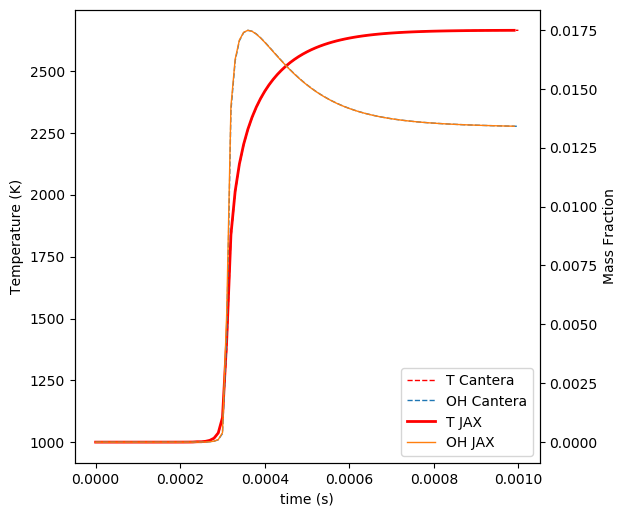

In [22]:
fig = plt.figure(figsize=(6,6),dpi=100)
L1 = plt.plot(states.t, states.T, ls='--', color='r', label='T Cantera', lw=1)
L1_rt = plt.plot(onp.asarray(ts), onp.asarray(ys[:,0]), ls='-',
                 color='r', label='T JAX', lw=2)
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')

plt.twinx()
L2 = plt.plot(states.t, states('OH').Y, ls='--', label='OH Cantera', lw=1)
L2_rt = plt.plot(onp.asarray(ts), onp.asarray(ys[:,gas.species_index('OH')+1]), ls='-', label='OH JAX', lw=1)
plt.ylabel('Mass Fraction')

plt.legend(L1+L2+L1_rt+L2_rt, [line.get_label()
                               for line in L1+L2+L1_rt+L2_rt], loc='lower right')
plt.show()